In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K
from keras.losses import mse, binary_crossentropy


Using TensorFlow backend.


In [136]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [137]:
from keras import metrics

In [138]:
import matplotlib.pyplot as plt

In [139]:
# MNIST dataset

#Loads the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size    # 28*28=784
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [140]:
epsilon_std=1

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [149]:
# network parameters
#batch_size - number of training examples 
#that are used at the same time to train the NN
#latent_dim - defines the dimentionality of the latent space
#2D latent space in this case
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 100

In [150]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [151]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_26[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_26[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [152]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [153]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_28 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [154]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [155]:
# Compute VAE loss
xent_loss = original_dim * binary_crossentropy(inputs, outputs)
kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [156]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 70us/step - loss: 193.0771 - val_loss: 171.3276
Epoch 2/100
60000/60000 [==============================] - 3s 55us/step - loss: 168.2521 - val_loss: 166.1052
Epoch 3/100
60000/60000 [==============================] - 3s 54us/step - loss: 164.1563 - val_loss: 163.0254
Epoch 4/100
60000/60000 [==============================] - 3s 56us/step - loss: 161.5463 - val_loss: 160.6482
Epoch 5/100
60000/60000 [==============================] - 3s 55us/step - loss: 159.6311 - val_loss: 159.2467
Epoch 6/100
60000/60000 [==============================] - 3s 56us/step - loss: 158.2508 - val_loss: 158.0975
Epoch 7/100
60000/60000 [==============================] - 3s 54us/step - loss: 157.2273 - val_loss: 157.1815
Epoch 8/100
60000/60000 [==============================] - 4s 62us/step - loss: 156.2993 - val_loss: 156.3898
Epoch 9/100
60000/60000 [==============================] - 4s 59us/ste

60000/60000 [==============================] - 3s 55us/step - loss: 144.2900 - val_loss: 149.3456
Epoch 75/100
60000/60000 [==============================] - 3s 54us/step - loss: 144.1961 - val_loss: 149.0383
Epoch 76/100
60000/60000 [==============================] - 3s 53us/step - loss: 144.1274 - val_loss: 149.1570
Epoch 77/100
60000/60000 [==============================] - 3s 55us/step - loss: 144.0776 - val_loss: 149.1427
Epoch 78/100
60000/60000 [==============================] - 3s 58us/step - loss: 144.0132 - val_loss: 148.7752
Epoch 79/100
60000/60000 [==============================] - 3s 53us/step - loss: 143.9322 - val_loss: 148.9536
Epoch 80/100
60000/60000 [==============================] - 3s 53us/step - loss: 143.8785 - val_loss: 148.7370
Epoch 81/100
60000/60000 [==============================] - 3s 57us/step - loss: 143.8656 - val_loss: 148.9471
Epoch 82/100
60000/60000 [==============================] - 4s 59us/step - loss: 143.7937 - val_loss: 149.0011
Epoch 83/100
6

In [160]:
def plot_results(models,
                 data,
                 batch_size=100,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [161]:
models = (encoder, decoder)
data = (x_test, y_test)

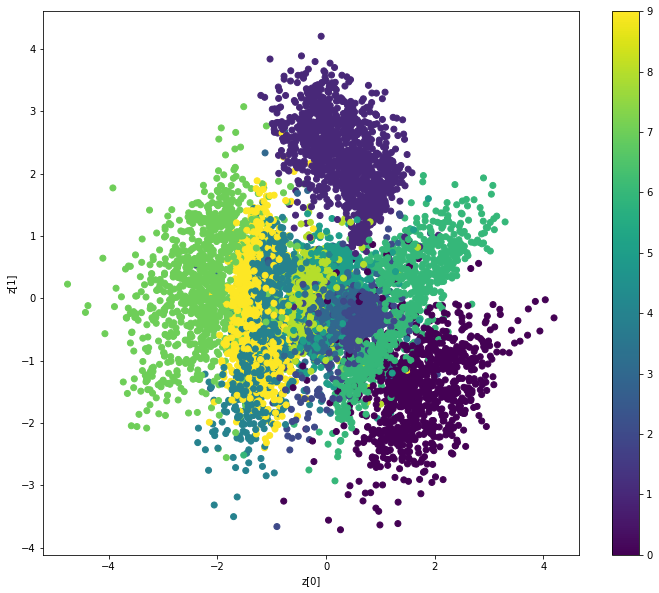

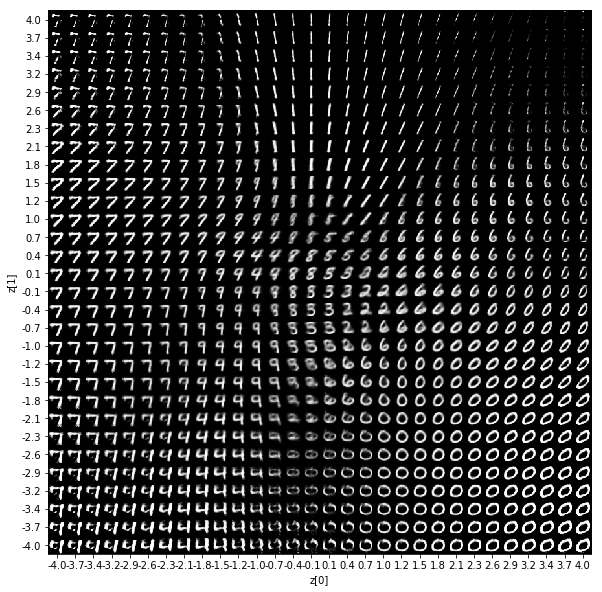

In [162]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

NameError: name 'dec' is not defined